___

<a href='http://www.pieriandata.com'> <img src='../Pierian_Data_Logo.png' /></a>
___

# Topic modeling com "Latent Dirichlet Allocation"

## Importe de pacotes


In [4]:
#Pacotes gerais
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import random

#NLTK
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

#sklearn
import pyLDAvis.sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy

#pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis




C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
npr = pd.read_csv('scopus_mais_recente.csv')
data = pd.read_csv('scopus_mais_recente.csv')

### CRIAÇÃO DE MODELO LDA COM O PACOTE GENSIM


In [7]:
data

Authors  \
0     Wang L.-S., Xu S., Gopal S., Kim E., Kim D., B...   
1     Kumar M., Kuroda K., Joshi M., Bhattacharya P....   
2          Roles J., Yarnold J., Hussey K., Hankamer B.   
3     Schwan J., Alva T.R., Nava G., Rodriguez C.B.,...   
4     Tan Q., He L., Meng X., Wang W., Pan H., Yin W...   
...                                                 ...   
1973  Zulauf K.E., Green A.B., Ba A.N.N., Jagdish T....   
1974                           Moelling K., Broecker F.   
1975                                         Barcelo D.   
1976  Ramírez-Malule H., Quiñones-Murillo D.H., Mano...   
1977  Zhu W., Wang Y., Xiao K., Zhang H., Tian Y., C...   

                                                  Title  Cited by  \
0     Facile fabrication of antibacterial and antivi...       NaN   
1     First comparison of conventional activated slu...       NaN   
2     Techno-economic evaluation of microalgae high-...       NaN   
3     Efficient facemask decontamination via forced ...       NaN   
4     Macrophage biomimetic nanocarriers for anti-in...       NaN   
...                                                 ...       ...   
1973  Microwave-generated steam decontamination of N...      18.0   
1974  Air Microbiome and Pollution: Composition and ...       8.0   
1975  An environmental and health perspective for CO...      57.0   
1976  Emerging contaminants as global environmental ...       7.0   
1977  Establishing and Managing a Temporary Coronavi...      23.0   

                                                   Link  \
0     https://www.scopus.com/inward/record.uri?eid=2...   
1     https://www.scopus.com/inward/record.uri?eid=2...   
2     https://www.scopus.com/inward/record.uri?eid=2...   
3     https://www.scopus.com/inward/record.uri?eid=2...   
4     https://www.scopus.com/inward/record.uri?eid=2...   
...                                                 ...   
1973  https://www.scopus.com/inward/record.uri?eid=2...   
1974  https://www.scopus.com/inward/record.uri?eid=2...   
1975  https://www.scopus.com/inward/record.uri?eid=2...   
1976  https://www.scopus.com/inward/record.uri?eid=2...   
1977  https://www.scopus.com/inward/record.uri?eid=2...   

                                               Abstract  \
0     In situ generation of antibacterial and antivi...   
1     In the initial pandemic phase, effluents from ...   
2     Background: Microalgae-based high-density fuel...   
3     The COVID-19 crisis has taken a significant to...   
4     Background: The worldwide pandemic of COVID-19...   
...                                                 ...   
1973  The severe acute respiratory syndrome coronavi...   
1974  Polluted air poses a significant threat to hum...   
1975  This Opinion Paper wishes to provide a summary...   
1976  This paper presents a bibliometric analysis of...   
1977                            [No abstract available]   

                                        Author Keywords  \
0                                                   NaN   
1     Conventional activated sludge process; COVID-1...   
2     Algae-based fuel; Energy production; Fuel secu...   
3                                                   NaN   
4     Anti-inflammation; Antiviral treatment; Biomim...   
...                                                 ...   
1973  COVID-19; Disinfection; MS2 phage; N95; Respir...   
1974                                                NaN   
1975  Air quality index; COVID-19; Drug therapies; H...   
1976  Adsorption processes; Advanced oxidation proce...   
1977                                                NaN   

                                         Index Keywords  
0                                                   NaN  
1                                                   NaN  
2     Algae; Biodiesel; Carbon dioxide; Competition;...  
3                                                   NaN  
4     Biomimetics; Controlled drug delivery; Macroph...  
...                                

In [8]:
#Stopwords para retirar dos abstracts
stopwords = stopwords.words("english")
print (stopwords)

In [10]:
#Função para criar o lema de uma palavra
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)


lemmatized_texts = lemmatization(data["Abstract"])
print(lemmatized_texts)

['situ generation antibacterial antiviral agent harness catalytic activity enzyme surface provide effective eco friendly approach disinfection perhydrolase act mycobacterium smegmatis catalyze perhydrolysis ester generate potent disinfectant peracetic acid presence substrate sufficient continuous generate extended time kill wide range bacteria enzyme dissolve aqueous buffer extended self disinfection however active stable act bind incorporate surface coating necessary current study active stable reusable act base coating develop incorporate polydopamine matrix single step thereby form biocatalytic composite variety surface result act pda composite coating glass metal epoxy surface yield 7-log reduction positive negative bacteria when contact biocatalytic coating composite coating also possess potent antiviral activity dramatically reduce infectivity cov-2 pseudovirus minute single step approach enable rapid facile fabrication enzyme base disinfectant composite coating high activity sta

In [12]:
#Função que quebra as frases em palavras singulares (retira as stopwords)
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

print(data_words)

[['situ', 'generation', 'antibacterial', 'antiviral', 'agent', 'harness', 'catalytic', 'activity', 'enzyme', 'surface', 'provide', 'effective', 'eco', 'friendly', 'approach', 'disinfection', 'perhydrolase', 'act', 'mycobacterium', 'smegmatis', 'catalyze', 'perhydrolysis', 'ester', 'generate', 'potent', 'disinfectant', 'peracetic', 'acid', 'presence', 'substrate', 'sufficient', 'continuous', 'generate', 'extended', 'time', 'kill', 'wide', 'range', 'bacteria', 'enzyme', 'dissolve', 'aqueous', 'buffer', 'extended', 'self', 'disinfection', 'however', 'active', 'stable', 'act', 'bind', 'incorporate', 'surface', 'coating', 'necessary', 'current', 'study', 'active', 'stable', 'reusable', 'act', 'base', 'coating', 'develop', 'incorporate', 'polydopamine', 'matrix', 'single', 'step', 'thereby', 'form', 'biocatalytic', 'composite', 'variety', 'surface', 'result', 'act', 'pda', 'composite', 'coating', 'glass', 'metal', 'epoxy', 'surface', 'yield', 'log', 'reduction', 'positive', 'negative', 'bact

In [80]:
id2word = corpora.Dictionary(data_words)

corpus = []
for text in data_words:
    new = id2word.doc2bow(text)
    corpus.append(new)

print (corpus[0][0:20])

word = id2word[[0][:1][0]]
print (word)

[(0, 1), (1, 4), (2, 2), (3, 3), (4, 1), (5, 1), (6, 2), (7, 3), (8, 1), (9, 2), (10, 1), (11, 1), (12, 2), (13, 2), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1)]
acid


In [97]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha="auto")

In [98]:
#Representação visual das palavras mais encontradas para cada topico gerado
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.014560  0.030618       1        1  20.651102
2     -0.101986 -0.360990       2        1  17.016568
0     -0.361661 -0.099126       3        1  16.327035
5     -0.269267  0.257385       4        1  15.546977
6      0.241865 -0.273515       5        1  11.485490
1      0.380377  0.075383       6        1   9.880305
3      0.125232  0.370245       7        1   9.092523, topic_info=              Term         Freq        Total Category  logprob  loglift
566          virus  1750.000000  1750.000000  Default  30.0000  30.0000
132          covid  1447.000000  1447.000000  Default  29.0000  29.0000
162       pandemic  1243.000000  1243.000000  Default  28.0000  28.0000
49          health  1354.000000  1354.000000  Default  27.0000  27.0000
898          water  1536.000000  1536.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
445         effect   168.917265   366.674449   Topic7  -4.8056   1.6227
644           risk   192.633873   631.930244   Topic7  -4.6742   1.2097
683       epidemic   144.913898   295.037045   Topic7  -4.9588   1.6868
331            use   188.604443  2155.567155   Topic7  -4.6953  -0.0384
243  environmental   158.007080   595.300995   Topic7  -4.8723   1.0713

[375 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
200       1  0.996795  abstract
1721      6  0.996383    access
569       4  0.990420    accord
0         5  0.996472      acid
665       2  0.993912    action
...     ...       ...       ...
663       7  0.088819      will
197       2  0.905548      work
197       5  0.091738      work
994       7  0.994202     world
853       2  0.988197     would

[486 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 1, 6, 7, 2, 4])

## CRIAÇÃO DE MODELO LDA COM O PACOTE SKLEARN

**`max_df`**` : float in range [0.0, 1.0] or int, default=1.0`<br>
( discarda palavras que aparecem em varios documentos, valor de 90% discarda palavras que aparecem em 90% dos documentos)

**`min_df`**` : float in range [0.0, 1.0] or int, default=1`<br>
(minimo de artigos em que aparecem as palavras numero inteiro 10 por exemplo significa que a palavra tem que aparecer um minimo de 10 vezes e 0.1 significa que tem de aparecer em pelo enos 10% dos documentos.


In [84]:
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

In [85]:
dtm = cv.fit_transform(npr['Abstract'])

In [86]:
dtm

<1978x9816 sparse matrix of type '<class 'numpy.int64'>'
	with 178874 stored elements in Compressed Sparse Row format>

In [87]:
#numero de componentes = numero de topicos
LDA = LatentDirichletAllocation(n_components=7,random_state=52)

In [88]:

LDA.fit(dtm)

LatentDirichletAllocation(n_components=7, random_state=52)

## Stored Words

In [89]:
#lista de palavras nos documentos
len(cv.get_feature_names())

9816

In [91]:
for i in range(10):
    random_word_id = random.randint(0,3274)
    print(cv.get_feature_names()[random_word_id])

causes
dimension
adjusted
advancement
detect
embrace
343
benchmarking
dangerous
disrupting


In [92]:
for i in range(10):
    random_word_id = random.randint(0,3274)
    print(cv.get_feature_names()[random_word_id])

016
certified
concerted
digitalisation
66
additive
clustering
cd
correlate
anticipate


### Top Words Per Topic

In [93]:
len(LDA.components_)

7

In [94]:
LDA.components_

array([[ 0.14525963, 33.76249455,  0.14398643, ...,  4.13181465,
         3.24135314,  0.14285715],
       [ 0.14294822,  0.23295451,  1.68997012, ...,  1.09567382,
         0.14292826,  0.14285715],
       [ 1.88577136, 10.56168071,  0.14300917, ...,  0.14285718,
         0.14307383,  0.14287809],
       ...,
       [ 1.37342071, 14.59827412,  8.20655442, ...,  0.19913784,
         6.78510068, 15.14266252],
       [ 6.71452418,  5.82449389,  0.14363528, ...,  0.14352582,
        29.2609883 ,  0.1429469 ],
       [ 3.59483739,  2.87711685,  4.52998741, ...,  0.14413347,
         4.2835688 ,  0.14285715]])

In [95]:
len(LDA.components_[0])

9816

In [96]:
single_topic = LDA.components_[0]

In [29]:
# Returns the indices that would sort this array.
single_topic.argsort()

array([8235, 7813, 5022, ..., 2497, 2369,  116], dtype=int64)

In [30]:
# Word least representative of this topic
single_topic[1498]

0.1428571566845842

In [31]:
# Word most representative of this topic
single_topic[763]

0.1446420522752645

In [32]:
# Top 10 words for this topic:
single_topic.argsort()[-10:]

array([ 152, 1595, 5821, 7763, 6468, 8629,  151, 2497, 2369,  116],
      dtype=int64)

In [33]:
top_word_indices = single_topic.argsort()[-10:]

In [34]:
for index in top_word_indices:
    print(cv.get_feature_names()[index])

2021
cases
model
results
pandemic
study
2020
data
covid
19


In [35]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['2021', 'cases', 'model', 'results', 'pandemic', 'study', '2020', 'data', 'covid', '19']


THE TOP 10 WORDS FOR TOPIC #1
['development', '2021', 'sustainable', 'use', 'production', 'management', 'food', 'environmental', 'energy', 'waste']


THE TOP 10 WORDS FOR TOPIC #2
['water', 'wastewater', 'transmission', 'virus', 'health', 'pandemic', 'cov', 'sars', '19', 'covid']


THE TOP 10 WORDS FOR TOPIC #3
['risk', 'development', 'methods', 'based', '2021', 'analysis', 'review', 'health', 'research', 'water']


THE TOP 10 WORDS FOR TOPIC #4
['method', 'viral', 'methods', 'based', 'detection', 'rna', 'sars', 'cov', 'samples', 'wastewater']


THE TOP 10 WORDS FOR TOPIC #5
['used', 'quality', 'mg', 'high', 'surface', 'adsorption', '2021', 'using', 'study', 'water']


THE TOP 10 WORDS FOR TOPIC #6
['transmission', 'patients', 'coronavirus', 'respiratory', 'viral', 'virus', 'covid', '19', 'sars', 'cov']




### Attaching Discovered Topic Labels to Original Articles

In [36]:
dtm

<1978x9816 sparse matrix of type '<class 'numpy.int64'>'
	with 178874 stored elements in Compressed Sparse Row format>

In [37]:
dtm.shape

(1978, 9816)

In [38]:
len(npr)

1978

In [39]:
topic_results = LDA.transform(dtm)

In [40]:
topic_results.shape

(1978, 7)

In [41]:
topic_results[0]

array([0.00092992, 0.00093227, 0.13113369, 0.00093235, 0.45888746,
       0.40625297, 0.00093134])

In [42]:
topic_results[0].round(2)

array([0.  , 0.  , 0.13, 0.  , 0.46, 0.41, 0.  ])

In [43]:
topic_results[0].argmax()

4

In [44]:
pyLDAvis.enable_notebook()
vis2 = pyLDAvis.sklearn.prepare(LDA, dtm, cv)
vis2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.016276 -0.123419       1        1  21.189899
5     -0.084918  0.204357       2        1  16.747641
1     -0.168706 -0.051580       3        1  16.340056
0      0.039906 -0.024373       4        1  12.827875
4      0.131718  0.122407       5        1  12.258074
3     -0.126803 -0.062745       6        1  10.696877
6      0.192527 -0.064647       7        1   9.939579, topic_info=            Term         Freq        Total Category  logprob  loglift
2358         cov  2019.000000  2019.000000  Default  30.0000  30.0000
7948        sars  2013.000000  2013.000000  Default  29.0000  29.0000
9638  wastewater  1448.000000  1448.000000  Default  28.0000  28.0000
2369       covid  2268.000000  2268.000000  Default  27.0000  27.0000
116           19  2298.000000  2298.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
4463       human   117.325772   692.360192   Topic7  -5.3199   0.5335
8953     testing    74.819626   203.957569   Topic7  -5.7698   1.3058
7836        risk    87.514886   472.004687   Topic7  -5.6131   0.6235
6468    pandemic    93.271505  1079.622660   Topic7  -5.5494  -0.1402
7763     results    85.742108   685.606367   Topic7  -5.6335   0.2297

[569 rows x 6 columns], token_table=      Topic      Freq Term
term                      
116       1  0.442088   19
116       2  0.014794   19
116       3  0.070490   19
116       4  0.279351   19
116       5  0.023497   19
...     ...       ...  ...
9764      7  0.927040   ww
9770      2  0.956799  xrd
9798      2  0.985649   zn
9799      2  0.976096  zno
9815      5  0.919334   φ6

[1400 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 2, 1, 5, 4, 7])

### Combining with Original Data

In [45]:
npr.head()

Authors  \
0  Wang L.-S., Xu S., Gopal S., Kim E., Kim D., B...   
1  Kumar M., Kuroda K., Joshi M., Bhattacharya P....   
2       Roles J., Yarnold J., Hussey K., Hankamer B.   
3  Schwan J., Alva T.R., Nava G., Rodriguez C.B.,...   
4  Tan Q., He L., Meng X., Wang W., Pan H., Yin W...   

                                               Title  Cited by  \
0  Facile fabrication of antibacterial and antivi...       NaN   
1  First comparison of conventional activated slu...       NaN   
2  Techno-economic evaluation of microalgae high-...       NaN   
3  Efficient facemask decontamination via forced ...       NaN   
4  Macrophage biomimetic nanocarriers for anti-in...       NaN   

                                                Link  \
0  https://www.scopus.com/inward/record.uri?eid=2...   
1  https://www.scopus.com/inward/record.uri?eid=2...   
2  https://www.scopus.com/inward/record.uri?eid=2...   
3  https://www.scopus.com/inward/record.uri?eid=2...   
4  https://www.scopus.com/inward/record.uri?eid=2...   

                                            Abstract  \
0  In situ generation of antibacterial and antivi...   
1  In the initial pandemic phase, effluents from ...   
2  Background: Microalgae-based high-density fuel...   
3  The COVID-19 crisis has taken a significant to...   
4  Background: The worldwide pandemic of COVID-19...   

                                     Author Keywords  \
0                                                NaN   
1  Conventional activated sludge process; COVID-1...   
2  Algae-based fuel; Energy production; Fuel secu...   
3                                                NaN   
4  Anti-inflammation; Antiviral treatment; Biomim...   

                                      Index Keywords  
0                                                NaN  
1                                                NaN  
2  Algae; Biodiesel; Carbon dioxide; Competition;...  
3                                                NaN  
4  Biomimetics; Controlled drug delivery; Macroph...

In [46]:
topic_results.argmax(axis=1)

array([4, 4, 1, ..., 2, 3, 4], dtype=int64)

In [47]:
npr['Topic'] = topic_results.argmax(axis=1)

In [48]:
npr.head(10)

Authors  \
0  Wang L.-S., Xu S., Gopal S., Kim E., Kim D., B...   
1  Kumar M., Kuroda K., Joshi M., Bhattacharya P....   
2       Roles J., Yarnold J., Hussey K., Hankamer B.   
3  Schwan J., Alva T.R., Nava G., Rodriguez C.B.,...   
4  Tan Q., He L., Meng X., Wang W., Pan H., Yin W...   
5  Marotz C., Belda-Ferre P., Ali F., Das P., Hua...   
6  Peters A., Palomo R., Ney H., Lotfinejad N., Z...   
7                Chan L.Y.H., Yuan B., Convertino M.   
8            Tavirani M.R., Moghaddasi H., Samadi L.   
9  Zhang Y., Gong C., Li D., Wang Z.-W., Pu S.D.,...   

                                               Title  Cited by  \
0  Facile fabrication of antibacterial and antivi...       NaN   
1  First comparison of conventional activated slu...       NaN   
2  Techno-economic evaluation of microalgae high-...       NaN   
3  Efficient facemask decontamination via forced ...       NaN   
4  Macrophage biomimetic nanocarriers for anti-in...       NaN   
5  SARS-CoV-2 detection status associates with ba...       NaN   
6  The COVID-19 pandemic and N95 masks: reusabili...       NaN   
7  COVID-19 non-pharmaceutical intervention portf...       NaN   
8  The role of systems biology and synthetic biol...       NaN   
9  A prognostic dynamic model applicable to infec...       NaN   

                                                Link  \
0  https://www.scopus.com/inward/record.uri?eid=2...   
1  https://www.scopus.com/inward/record.uri?eid=2...   
2  https://www.scopus.com/inward/record.uri?eid=2...   
3  https://www.scopus.com/inward/record.uri?eid=2...   
4  https://www.scopus.com/inward/record.uri?eid=2...   
5  https://www.scopus.com/inward/record.uri?eid=2...   
6  https://www.scopus.com/inward/record.uri?eid=2...   
7  https://www.scopus.com/inward/record.uri?eid=2...   
8  https://www.scopus.com/inward/record.uri?eid=2...   
9  https://www.scopus.com/inward/record.uri?eid=2...   

                                            Abstract  \
0  In situ generation of antibacterial and antivi...   
1  In the initial pandemic phase, effluents from ...   
2  Background: Microalgae-based high-density fuel...   
3  The COVID-19 crisis has taken a significant to...   
4  Background: The worldwide pandemic of COVID-19...   
5  Background: SARS-CoV-2 is an RNA virus respons...   
6  Background: With the current SARS-CoV-2 pandem...   
7  Non-pharmaceutical interventions (NPIs) includ...   
8  Studies reveal that viruses play important rol...   
9  A reasonable prediction of infectious diseases...   

                                     Author Keywords  \
0                                                NaN   
1  Conventional activated sludge process; COVID-1...   
2  Algae-based fuel; Energy production; Fuel secu...   
3                                                NaN   
4  Anti-inflammation; Antiviral treatment; Biomim...   
5  16S rRNA; Built environment; COVID-19; Microbi...   
6  COVID-19; Disinfection; Face masks; FFP2; Heal...   
7                                                NaN   
8  Bioterrorism; COVID-19; Pandemic viral disease...   
9                                                NaN   

                                      Index Keywords  Topic  
0                                                NaN      4  
1                                                NaN      4  
2  Algae; Biodiesel; Carbon dioxide; Competition;...      1  
3                                                NaN      1  
4  Biomimetics; Controlled drug delivery; Macroph...      0  
5  RNA 16S; virus RNA; RNA 16S; virus RNA; amplic...      6  
6  ethylene oxide; hydrogen peroxide; decontamina...      2  
7                                                NaN      0  
8                                                NaN      3  
9  diagnosis; epidemiology; human; isolation and ...      0

In [99]:
#Contar as publicações para cada topico 
topicos = dict(Counter(list(npr["Topic"])))
topicos2 = dict(sorted(topicos.items()))

print(topicos2)



{0: 210, 1: 313, 2: 461, 3: 197, 4: 328, 5: 326, 6: 143}


In [50]:
def contar_pubs(lista):
    lista_top = []
    lista_cont = []
    for key in topicos2.keys():
        lista_top.append("Topic"+ " " + str(key))
    for value in topicos2.values():
        lista_cont.append(value)
    return lista_top, lista_cont


['Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6']
[210, 313, 461, 197, 328, 326, 143]


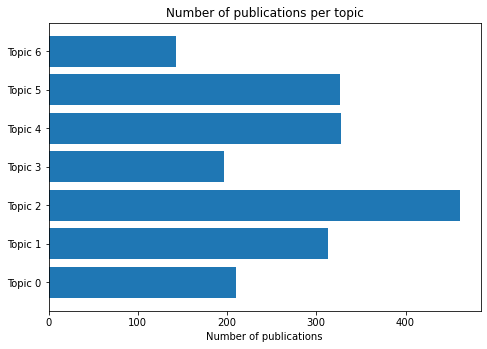

In [101]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
top = contar_pubs(topicos2)[0]
print(top)
cont = contar_pubs(topicos2)[1]
print(cont)
ax.barh(top,cont)
plt.xlabel('Number of publications')
plt.title("Number of publications per topic")
plt.show()


### Sentiment Analysis

In [52]:
sid = SentimentIntensityAnalyzer()

In [53]:
npr['scores'] = npr['Abstract'].apply(lambda review: sid.polarity_scores(review))

npr['compound']  = npr['scores'].apply(lambda score_dict: score_dict['compound'])

npr['comp_score'] = npr['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')


In [133]:
t = list(npr["comp_score"])

#t.count("pos")
#t.count("neg")

In [105]:
sum(list(npr["Autor filtrado"]))

22

# Calculo H-INDEX

In [125]:
#Top 10 autores mais representados no scopus
lista_autores = ["Kumar M." , "Bibby K." , "Ahmed W." ,"Kitajima M.", "Bivins A.","Galanakis C.M.","Klemeš J.J.","Kuroda K.","Dhama K.","Dhangar K."]

import math
from scholarmetrics import hindex
lista_a = []
lista_h = []


for autor in lista_autores:
    #Cria um filtro para procurar (com boleanos True ou False) os nomes dos autores principais nas células dos autores, seguidamente 
    #é adicionado uma coluna com esses boleanos no dataframe e posteriormente selecionadas as linhas cuja valor para o autor filtrado seja True
    filtro_autor = npr["Authors"].str.contains(autor, regex = False)
    npr["Autor filtrado"] = filtro_autor
    filtro = npr.loc[npr["Autor filtrado"] == True]
    
    #Calcula o valor de h index
    lista_cita = list(filtro["Cited by"])
    citations = [x for x in lista_cita if math.isnan(x) == False]
    hdex = hindex(citations)
    lista_h.append(hdex)
    lista_a.append(autor)
    
    print("Autor:" + autor + ";" + "hindex: " + str(hdex))
  

Autor:Kumar M.;hindex: 9
Autor:Bibby K.;hindex: 10
Autor:Ahmed W.;hindex: 9
Autor:Kitajima M.;hindex: 11
Autor:Bivins A.;hindex: 9
Autor:Galanakis C.M.;hindex: 5
Autor:Klemeš J.J.;hindex: 4
Autor:Kuroda K.;hindex: 6
Autor:Dhama K.;hindex: 3
Autor:Dhangar K.;hindex: 4
['Kumar M.', 'Bibby K.', 'Ahmed W.', 'Kitajima M.', 'Bivins A.', 'Galanakis C.M.', 'Klemeš J.J.', 'Kuroda K.', 'Dhama K.', 'Dhangar K.']
[9, 10, 9, 11, 9, 5, 4, 6, 3, 4]


['Kumar M.', 'Bibby K.', 'Ahmed W.', 'Kitajima M.', 'Bivins A.', 'Galanakis C.M.', 'Klemeš J.J.', 'Kuroda K.', 'Dhama K.', 'Dhangar K.']
[9, 10, 9, 11, 9, 5, 4, 6, 3, 4]


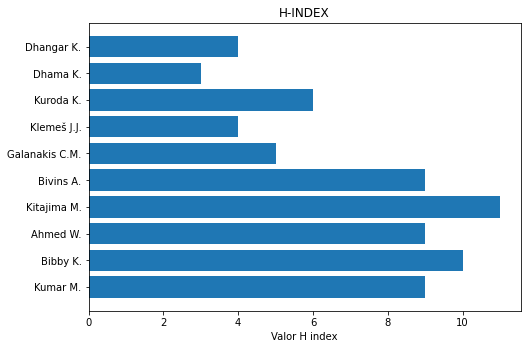

In [127]:
#Grafico para reperesentar o valor de H-INDEX

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
top = lista_a
print(top)
cont = lista_h
print(cont)
ax.barh(top,cont)
plt.xlabel('Valor H index')
plt.title("H-INDEX")
plt.show()

## Sentiment Analysis para um unico Autor

In [135]:
#Exemplo para Ahmed W.
#Mudar o nome autor para filtrar por autor
autor = "Kitajima M."

#Cria um filtro para ver se a celula dos autores contem a string indicada acima
filtro_autor = npr["Authors"].str.contains(autor, regex = False)
npr["Autor filtrado"] = filtro_autor


filtro = npr.loc[npr["Autor filtrado"] == True]
filtro
    

Authors  \
418                     Miura F., Kitajima M., Omori R.   
534   Zhu Y., Oishi W., Maruo C., Saito M., Chen R.,...   
758   Kumar M., Mazumder P., Mohapatra S., Kumar Tha...   
962   Ahmed W., Bivins A., Bertsch P.M., Bibby K., G...   
1012  Takeda T., Kitajima M., Huong N.T.T., Setiyawa...   
1374  Ahmed W., Bertsch P.M., Angel N., Bibby K., Bi...   
1411  Bivins A., Greaves J., Fischer R., Yinda K.C.,...   
1457  Ahmed W., Bertsch P.M., Bibby K., Haramoto E.,...   
1498  Sherchan S.P., Shahin S., Ward L.M., Tandukar ...   
1595  Ahmed W., Bertsch P.M., Bivins A., Bibby K., F...   
1596  Kitajima M., Ahmed W., Bibby K., Carducci A., ...   
1610  Ahmed W., Bivins A., Bertsch P.M., Bibby K., C...   
1667     Haramoto E., Malla B., Thakali O., Kitajima M.   
1793  Ahmed W., Angel N., Edson J., Bibby K., Bivins...   
1803  Kumar M., Kuroda K., Dhangar K., Mazumder P., ...   
1812  Bivins A., North D., Ahmad A., Ahmed W., Alm E...   

                                                  Title  Cited by  \
418   Duration of SARS-CoV-2 viral shedding in faece...       1.0   
534   Early warning of COVID-19 via wastewater-based...       2.0   
758   A chronicle of SARS-CoV-2: Seasonality, enviro...      16.0   
962   Intraday variability of indicator and pathogen...       6.0   
1012  Institutionalising wastewater surveillance sys...       NaN   
1374  Detection of SARS-CoV-2 RNA in commercial pass...      23.0   
1411  Persistence of SARS-CoV-2 in Water and Wastewater      42.0   
1457  Decay of SARS-CoV-2 and surrogate murine hepat...      50.0   
1498  First detection of SARS-CoV-2 RNA in wastewate...      81.0   
1595  Comparison of virus concentration methods for ...      89.0   
1596  SARS-CoV-2 in wastewater: State of the knowled...     157.0   
1610  Surveillance of SARS-CoV-2 RNA in wastewater: ...       9.0   
1667  First environmental surveillance for the prese...     101.0   
1793  First confirmed detection of SARS-CoV-2 in unt...     345.0   
1803  Potential Emergence of Antiviral-Resistant Pan...      11.0   
1812  Wastewater-Based Epidemiology: Global Collabor...      62.0   

                                                   Link  \
418   https://www.scopus.com/inward/record.uri?eid=2...   
534   https://www.scopus.com/inward/record.uri?eid=2...   
758   https://www.scopus.com/inward/record.uri?eid=2...   
962   https://www.scopus.com/inward/record.uri?eid=2...   
1012  https://www.scopus.com/inward/record.uri?eid=2...   
1374  https://www.scopus.com/inward/record.uri?eid=2...   
1411  https://www.scopus.com/inward/record.uri?eid=2...   
1457  https://www.scopus.com/inward/record.uri?eid=2...   
1498  https://www.scopus.com/inward/record.uri?eid=2...   
1595  https://www.scopus.com/inward/record.uri?eid=2...   
1596  https://www.scopus.com/inward/record.uri?eid=2...   
1610  https://www.scopus.com/inward/record.uri?eid=2...   
1667  https://www.scopus.com/inward/record.uri?eid=2...   
1793  https://www.scopus.com/inward/record.uri?eid=2...   
1803  https://www.scopus.com/inward/record.uri?eid=2...   
1812  https://www.scopus.com/inward/record.uri?eid=2...   

                                               Abstract  \
418   Wastewater-based epidemiology (WBE) is one of ...   
534   An effective early warning tool is of great ad...   
758   In this review, we present the environmental p...   
962   We monitored the concentration of indicator vi...   
1012  This mini review describes the current status ...   
1374  Background: Wastewater-based epidemiology (WBE...   
1411  Severe acute respiratory syndrome coronavirus ...   
1457  Wastewater-based epidemiology (WBE) demonstrat...   
1498  We investigated the presence of severe acute r...   
1595  There is currently a clear benefit for many co...   
1596  The ongoing global pandemic of coronavirus dis...   
1610  Monitoring for SARS-CoV-2 RNA in wastewater th...   
1667  Wastewater-based epidemiology is a powerful to...   
1793  Infection with SARS-CoV-2, the eti

In [149]:
print("Numero de artigos para o autor")
print(sum(list(filtro["Autor filtrado"])))
senti = list(filtro["comp_score"])
print("Artigos com sentiment positivo")
print(senti.count("pos"))
print("Artigos com sentiment negativo")
print(senti.count("neg"))


Numero de artigos para o autor
16
Artigos com sentiment positivo
12
Artigos com sentiment negativo
4


In [152]:
titu = list(filtro["Title"])
comp = list(filtro["compound"])

In [163]:
#Função que vai buscar o top artigos com sentiment mais negativo e positivo. Necessita da coluna com o titulo dos artigo, 
#a coluna com os valores resultantes do compound e o numero de publicações a mostrar para cada sentimento (positivo e negativo, default é 5)
def top_pubs(titulo, compound, num_pubs = 5):
    dic_results = {}
    for tit, comp in zip(titulo,compound):
        dic_results[tit] = comp
    
    # Create a list of tuples sorted by index 1 i.e. value field     
    listofTuples = sorted(dic_results.items() , reverse=True, key=lambda x: x[1])
    #print(listofTuples)
    
    piores = listofTuples[-num_pubs:]
    melhores = listofTuples[:num_pubs]
    
    print("MAIS NEGATIVOS: ")
    print()
    for pubs in piores:
        print(str(pubs[0]))
        print("---------------")
        print(str(pubs[1]))
        print("---------------")
        print()
    
    print()
    print()
    
    print("MAIS POSITIVOS: ")
    print()
    for pubs in melhores:
        print(str(pubs[0]))
        print("---------------")
        print(str(pubs[1]))
        print("---------------")
        print()
    
    

In [164]:
artigos = top_pubs(titu, comp)
artigos

MAIS NEGATIVOS: 

Wastewater-Based Epidemiology: Global Collaborative to Maximize Contributions in the Fight against COVID-19
---------------
0.0
---------------

Persistence of SARS-CoV-2 in Water and Wastewater
---------------
-0.27
---------------

A chronicle of SARS-CoV-2: Seasonality, environmental fate, transport, inactivation, and antiviral drug resistance
---------------
-0.4921
---------------

SARS-CoV-2 in wastewater: State of the knowledge and research needs
---------------
-0.5187
---------------

Decay of SARS-CoV-2 and surrogate murine hepatitis virus RNA in untreated wastewater to inform application in wastewater-based epidemiology
---------------
-0.8807
---------------



MAIS POSITIVOS: 

Comparison of virus concentration methods for the RT-qPCR-based recovery of murine hepatitis virus, a surrogate for SARS-CoV-2 from untreated wastewater
---------------
0.9715
---------------

Institutionalising wastewater surveillance systems to minimise the impact of COVID-19: Ca